In [1]:
!pip install emoji

     |████████████████████████████████| 175 kB 8.5 MB/s 
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=d056fe11c317525deeb48863f99d50a7f18a76b0eeb694f86d5ad68adbe580be
  Stored in directory: /root/.cache/pip/wheels/8a/4e/b6/57b01db010d17ef6ea9b40300af725ef3e210cb1acfb7ac8b6
Successfully built emoji


In [2]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sb

import os
import nltk
from nltk.corpus import stopwords
import seaborn as sns
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB,MultinomialNB,ComplementNB,BernoulliNB

import re
import emoji

from collections import Counter
from sklearn.datasets import make_classification

from imblearn.under_sampling import RandomUnderSampler
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

from nltk import FreqDist
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
from google.colab import files
uploaded=files.upload()

Saving offenseval-training-v1.tsv to offenseval-training-v1.tsv


In [4]:
import numpy as np
import pandas as pd
train_data=pd.read_csv("offenseval-training-v1.tsv",sep='\t')
train_data

,id,tweet,subtask_a,subtask_b,subtask_c
0,86426,@USER She should ask a few native Americans wh...,OFF,UNT,NaN
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,IND
2,16820,Amazon is investigating Chinese employees who ...,NOT,NaN,NaN
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,UNT,NaN
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,NaN,NaN
...,...,...,...,...,...
13235,95338,@USER Sometimes I get strong vibes from people...,OFF,TIN,IND
13236,67210,Benidorm ✅ Creamfields ✅ Maga ✅ Not too sh...,NOT,NaN,NaN
13237,82921,@USER And why report this garbage. We don't g...,OFF,TIN,OTH
13238,27429,@USER Pussy,OFF,UNT,NaN


In [5]:
array = ['GRP', 'IND']
train_data.loc[train_data['subtask_c'].isin(array)]

,id,tweet,subtask_a,subtask_b,subtask_c
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,IND
7,52415,@USER was literally just talking about this lo...,OFF,TIN,GRP
9,13384,@USER Canada doesn’t need another CUCK! We alr...,OFF,TIN,IND
12,28414,@USER you are a lying corrupt traitor!!! Nobod...,OFF,TIN,IND
20,56117,@USER @USER @USER @USER LOL!!! Throwing the ...,OFF,TIN,IND
...,...,...,...,...,...
13207,86716,@USER Omg not even interested in his age but d...,OFF,TIN,IND
13212,93164,@USER @USER Everything else was ten years ago....,OFF,TIN,IND
13223,63482,@USER is advocating for conduct within bounds ...,OFF,TIN,GRP
13227,87416,@USER @USER @USER @USER Liars like the Antifa ...,OFF,TIN,GRP


In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13240 entries, 0 to 13239
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         13240 non-null  int64 
 1   tweet      13240 non-null  object
 2   subtask_a  13240 non-null  object
 3   subtask_b  4400 non-null   object
 4   subtask_c  3876 non-null   object
dtypes: int64(1), object(4)
memory usage: 517.3+ KB


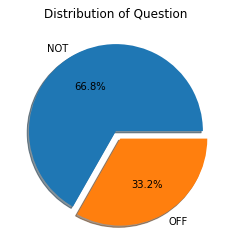

In [7]:
ax=train_data['subtask_a'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%' ,shadow=True)
ax.set_title('Distribution of Question')
ax.set_ylabel('')
plt.show()

Offensive:  4400
Not Offensive :  8840


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


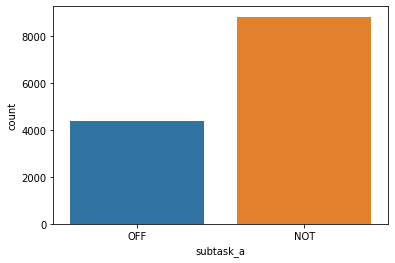

In [8]:
plot_sb = sb.countplot(train_data['subtask_a'], label='Total')
NOT, OFF  = train_data['subtask_a'].value_counts()
print('Offensive: ',OFF)
print('Not Offensive : ',NOT)

In [9]:
def handle_emoji(text):
    # Dictionnary of "important" emojis : 
    emoji_dict =  {'♥️': ' love ',
                   '❤️' : ' love ',
                   '❤' : ' love ',
                   '😘' : ' kisses ',
                  '😭' : ' cry ',
                  '💪' : ' strong ',
                  '🌍' : ' earth ',
                  '💰' : ' money ',
                  '👍' : ' ok ',
                   '👌' : ' ok ',
                  '😡' : ' angry ',
                  '🍆' : ' dick ',
                  '🤣' : ' haha ',
                  '😂' : ' haha ',
                  '🖕' : ' fuck you '}

    for cha in emoji_dict:
        text = re.compile(str(cha)).sub(str(emoji_dict[cha]),text)
    # Remove ALL emojis
    text = emoji.get_emoji_regexp().sub(r' ',text) 
    text = re.compile("([\U0001f3fb-\U0001f3ff])").sub(r'',text) 
    text = re.compile("([\U00010000-\U0010ffff])").sub(r'',text) 
    text = re.compile("(\u00a9|\u00ae|[\u2000-\u3300]|\ud83c[\ud000-\udfff]|\ud83d[\ud000-\udfff]|\ud83e[\ud000-\udfff])").sub(r'',text)

    # Add Space between  the Emoji Expressions : 
    text = re.compile("([\U00010000-\U0010ffff])").sub(r' \1 ',text) 
    return text

In [10]:
def clean_tweet(text):
    ''' Function that is applied to every to tweet in the dataset '''

    # =========== TEXT ===========
    # Replace @USER by <user>
    text = re.compile(r'@USER').sub(r'<user>',text)

    # Replace URL by <url>
    text = re.compile(r'URL').sub(r'<url>',text)

    # Remove numbers :
    text = re.compile(r'[0-9]+').sub(r' ',text)

    # Remove some special characters
    text = re.compile(r'([\xa0_\{\}\[\]¬•$,:;/@#|\^*%().~`”"“-])').sub(r' ',text) 

    # Space the special characters with white spaces
    text = re.compile(r'([$&+,:;=?@#|\'.^*()%!"’“-])').sub(r' \1 ',text)

    # Replace some special characters : 
    replace_dict = {r'&' : 'and' , r'&amp;' : 'and' , 
                    r'\+' : 'plus'}
    for cha in replace_dict:
        text = re.compile(str(cha)).sub(str(replace_dict[cha]),text)

    # Handle Emoji : translate some and delete the others
    text = handle_emoji(text)

    # Word delengthening : 
    text = re.compile(r'(.)\1{3,}').sub(r'\1\1',text)

    # Cut the words with caps in them : 
    text = re.compile(r'([a-z]+|[A-Z]+|[A-Z][a-z]+)([A-Z][a-z]+)').sub(r'\1 \2',text)
    text = re.compile(r'([a-z]+|[A-Z]+|[A-Z][a-z]+)([A-Z][a-z]+)').sub(r'\1 \2',text)        
    # =========== TOKENS ===========
    # TOKENIZE 
    text = text.split(' ')
    # Remove white spaces tokens
    text = [text[i] for i in range(len(text)) if text[i] != ' ']

    # Remove empty tokens
    text = [text[i] for i in range(len(text)) if text[i] != '']

    # Remove repetition in tokens (!!! => !)
    text = [text[i] for i in range(len(text)) if text[i] != text[i-1]]

    #  Handle the ALL CAPS Tweets 
    ### if ratio of caps in the word > 75% add allcaps tag <allcaps>
    caps_r = np.mean([text[i].isupper() for i in range(len(text))])
    if caps_r > 0.6 : 
        text.append('<allcaps>')

    # Lower Case : 
    text = [text[i].lower() for i in range(len(text))]
    
    return " ".join(str(x) for x in text)

In [11]:
train_data['subtask_a'].replace({'NOT':0, 'OFF': 1}, inplace= True)
train_data["preprocessed_tweet"] = train_data["tweet"].apply(clean_tweet)
train_data.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: 'emoji.get_emoji_regexp()' is deprecated and will be removed in version 2.0.0. If you want to remove emoji from a string, consider the method emoji.replace_emoji(str, replace='').
To hide this warning, pin/downgrade the package to 'emoji~=1.6.3'


,id,tweet,subtask_a,subtask_b,subtask_c,preprocessed_tweet
0,86426,@USER She should ask a few native Americans wh...,1,UNT,NaN,<user> she should ask a few native americans w...
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,1,TIN,IND,<user> go home you re drunk ! <user> maga trum...
2,16820,Amazon is investigating Chinese employees who ...,0,NaN,NaN,amazon is investigating chinese employees who ...
3,62688,"@USER Someone should'veTaken"" this piece of sh...",1,UNT,NaN,<user> someone should ' ve taken this piece of...
4,43605,@USER @USER Obama wanted liberals &amp; illega...,0,NaN,NaN,<user> obama wanted liberals and amp illegals ...


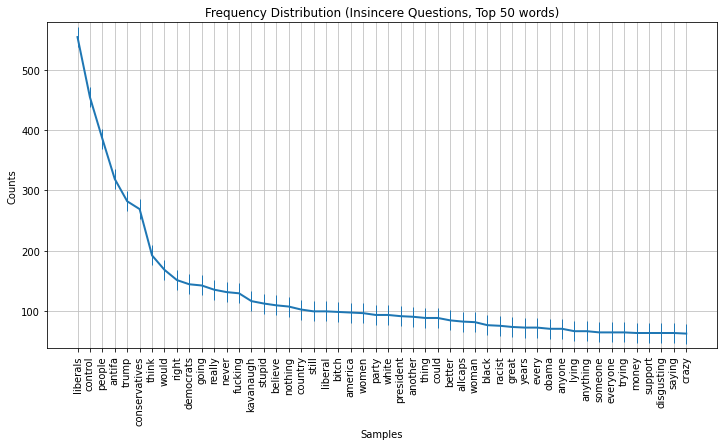

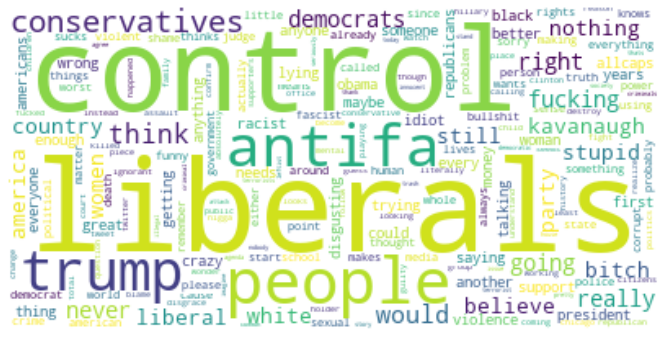

In [12]:
offensive = train_data.loc[train_data['subtask_a'] == 1].values
len(offensive)
offensive[0][1]

stop_words = set(stopwords.words('english'))
word_tokens = [word_tokenize(question[5]) for question in offensive]

#freq_dist = FreqDist([word for question in insincere_questions for word in question[1].split()])
all_words = [word for question in word_tokens for word in question]
len(all_words)
without_stopwords = [w for w in all_words if not w in stop_words]
words_len = [w for w in without_stopwords if not len(w)<5]
freq_dist = FreqDist([word for word in words_len])

plt.figure(figsize=(12,6))
plt.title(f'Frequency Distribution (Insincere Questions, Top 50 words)')
freq_dist.plot(50, marker='|', markersize=20)
plt.show()

from wordcloud import WordCloud

wordcloud = WordCloud(background_color='White').generate_from_frequencies(freq_dist)
plt.figure(figsize=(12,6))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

In [13]:
X = train_data["preprocessed_tweet"].values
y = train_data["subtask_a"].values
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(X, y, stratify=y, test_size=0.25)
#train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, stratify=train_y, test_size=0.1)
print("Train shape : ",train_X.shape)
#print("Validation shape : ",val_X.shape)
print("Test shape : ",test_X.shape)

Train shape :  (9930,)
Test shape :  (3310,)


In [14]:
unique, counts = np.unique(train_y, return_counts=True)
print(np.asarray((unique, counts)).T)

# unique, counts = np.unique(val_y, return_counts=True)
# print(np.asarray((unique, counts)).T)

unique, counts = np.unique(test_y, return_counts=True)
print(np.asarray((unique, counts)).T)

[[   0 6630]
 [   1 3300]]
[[   0 2210]
 [   1 1100]]


In [15]:
testdf = pd.DataFrame()
testdf['tweet'] = test_X

testdf['subtask_a'] = test_y
testdf.shape

(3310, 2)

In [16]:
def tfidf_vectorizer(X, train_X, test_X):
    
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_vectorizer.fit(X)

    train_text_features_tf = tfidf_vectorizer.transform(train_X)
    test_text_features_tf = tfidf_vectorizer.transform(test_X)
    
    return train_text_features_tf, test_text_features_tf

In [17]:
def count_vectorizer(X, train_X, test_X):
    
    count_vectorizer = CountVectorizer()
    count_vectorizer.fit(X)

    train_text_features_cv = count_vectorizer.transform(train_X)
    test_text_features_cv = count_vectorizer.transform(test_X)
    
    return train_text_features_cv, test_text_features_cv

In [18]:
def undersampleData(train_text_features_tf, train_y):
    rus = RandomUnderSampler(random_state=0)
    X_resampled, y_resampled = rus.fit_resample(train_text_features_tf, train_y)
    return X_resampled, y_resampled

In [19]:
def oversampleData(train_text_features_tf, train_y):
    from imblearn.over_sampling import SMOTE
    smote = SMOTE('minority')
    x_oversampled, y_oversampled = smote.fit_sample(train_text_features_tf, train_y)
    return x_oversampled, y_oversampled

In [20]:
def getConfusionMatrix(y_test, y_pred):
  # Confusion matrix
  mat = confusion_matrix(y_test, y_pred)
  cm = pd.DataFrame(mat)
  TP = cm.iloc[1,1] # True Positive
  TN = cm.iloc[0,0] # True Negative
  FP = cm.iloc[0,1] # False Positive
  FN = cm.iloc[1,0] # False Negative

  print('Sensitivity: {:.2%}'.format(TP/(FN+TP)))
  print('Specificity: {:.2%}'.format(TN/(FP+TN)))
  
  sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True)
  plt.title('A confusion matrix showing the frequency of misclassifications by our classifier')
  plt.xlabel('true label')
  plt.ylabel('predicted label');
  plt.show()

In [21]:
def model(model, X, train_X, train_y, test_X, test_y, tfidf = True, cv = False, undersampled = False, oversample = False):
    
    if tfidf:
        print('Feature Extraction using TFIFD')
        train_text_features, test_text_features = tfidf_vectorizer(X, train_X, test_X)
    
    if cv:
        print('Feature Extraction using CV')
        train_text_features, test_text_features = count_vectorizer(X, train_X, test_X)

    if undersampled:
        print('Undersampling the dataset')
        train_text_features, train_y = undersampleData(train_text_features, train_y)

    if oversample:
        print('Oversampling the dataset')
        train_text_features, train_y = oversampleData(train_text_features, train_y)
        
    model.fit(train_text_features, train_y)

    # predict the labels on validation dataset
    predictions = model.predict(test_text_features)

    # Use accuracy_score function to get the accuracy
    print("Accuracy Score -> ",accuracy_score(predictions, test_y)*100)

    print('F1Score', f1_score(predictions, test_y, average="macro"))
    print('Precision', precision_score(predictions, test_y, average="macro"))
    print('Recall', recall_score(predictions, test_y, average="macro"))

    getConfusionMatrix(test_y, predictions)

Feature Extraction using TFIFD
Undersampling the dataset
Accuracy Score ->  65.86102719033232
F1Score 0.6507035424411585
Precision 0.6852139037433155
Recall 0.6645803603803819
Sensitivity: 76.45%
Specificity: 60.59%


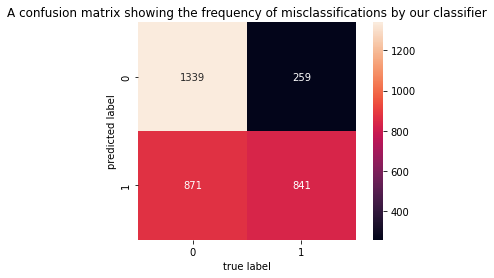

In [22]:
model(naive_bayes.MultinomialNB(), X, train_X, train_y,
      test_X, test_y, tfidf = True, cv = False, undersampled = True, oversample = False)

Feature Extraction using CV
Undersampling the dataset
Accuracy Score ->  64.83383685800604
F1Score 0.6401937375234588
Precision 0.673640477169889
Recall 0.6542962581731837
Sensitivity: 74.91%
Specificity: 59.82%


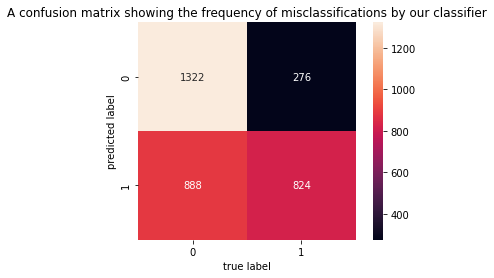

In [23]:
model(naive_bayes.MultinomialNB(), X, train_X, train_y,
      test_X, test_y, tfidf = False, cv = True, undersampled = True, oversample = False)

Feature Extraction using CV
Accuracy Score ->  73.17220543806646
F1Score 0.6756736716245579
Precision 0.6673652817770465
Recall 0.6970305823192819
Sensitivity: 47.55%
Specificity: 85.93%


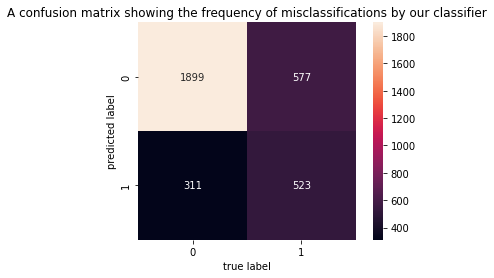

In [24]:
model(naive_bayes.MultinomialNB(), X, train_X, train_y,
      test_X, test_y, tfidf = False, cv = True, undersampled = False, oversample = False)

Feature Extraction using TFIFD
Accuracy Score ->  69.57703927492447
F1Score 0.5012920410837794
Precision 0.5479802550390785
Recall 0.7575511006202513
Sensitivity: 10.73%
Specificity: 98.87%


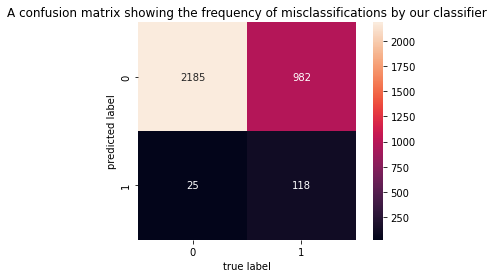

In [25]:
model(naive_bayes.MultinomialNB(), X, train_X, train_y,
      test_X, test_y, tfidf = True, cv = False, undersampled = False, oversample = False)

Feature Extraction using TFIFD
Undersampling the dataset
Accuracy Score ->  72.3262839879154
F1Score 0.700093969158333
Precision 0.7098868778280543
Recall 0.6958074295801673
Sensitivity: 67.00%
Specificity: 74.98%


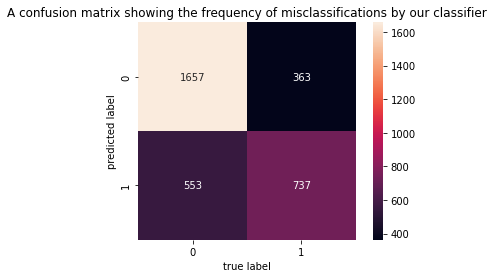

In [26]:
model(svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto'), X, train_X, train_y,
      test_X, test_y, tfidf = True, cv = False, undersampled = True, oversample = False)

Feature Extraction using CV
Undersampling the dataset
Accuracy Score ->  70.60422960725076
F1Score 0.6826308578751128
Precision 0.6928815302344714
Recall 0.6789205052564421
Sensitivity: 65.36%
Specificity: 73.21%


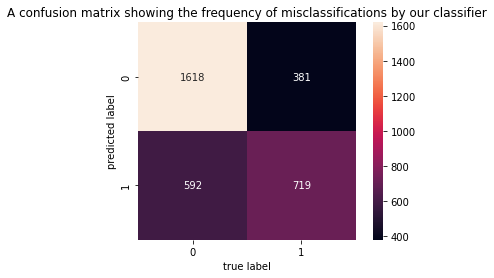

In [27]:
model(svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto'), X, train_X, train_y,
      test_X, test_y, tfidf = False, cv = True, undersampled = True, oversample = False)

Feature Extraction using CV
Accuracy Score ->  75.22658610271903
F1Score 0.7094999571881153
Precision 0.7026120937885644
Recall 0.7210925576802226
Sensitivity: 55.45%
Specificity: 85.07%


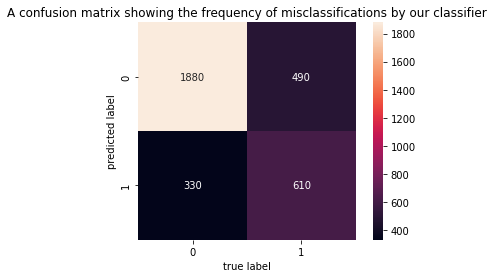

In [28]:
model(svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto'), X, train_X, train_y,
      test_X, test_y, tfidf = False, cv = True, undersampled = False, oversample = False)

Feature Extraction using TFIFD
Accuracy Score ->  76.85800604229607
F1Score 0.6984784187770934
Precision 0.6837803373097491
Recall 0.7698955624933548
Sensitivity: 43.09%
Specificity: 93.67%


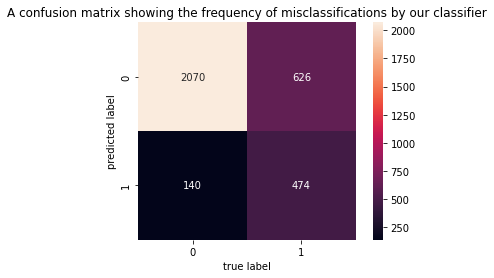

In [29]:
model(svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto'), X, train_X, train_y,
      test_X, test_y, tfidf = True, cv = False, undersampled = False, oversample = False)

Feature Extraction using CV


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Accuracy Score ->  76.34441087613293
F1Score 0.7079362725382701
Precision 0.6954586589880708
Recall 0.743611703984812
Sensitivity: 49.27%
Specificity: 89.82%


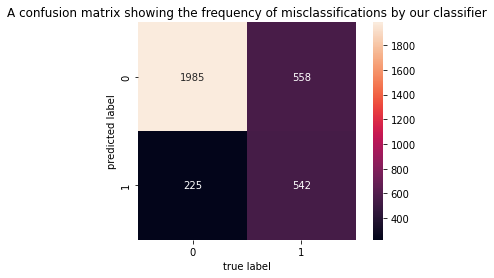

In [30]:
from sklearn.linear_model import LogisticRegression

model(LogisticRegression(), X, train_X, train_y,
      test_X, test_y, tfidf = False, cv = True, undersampled = False, oversample = False)

Feature Extraction using TFIFD
Accuracy Score ->  75.46827794561933
F1Score 0.6624824191279887
Precision 0.65282599753188
Recall 0.7734982332155478
Sensitivity: 34.91%
Specificity: 95.66%


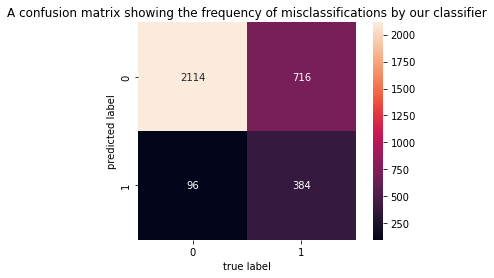

In [31]:
from sklearn.linear_model import LogisticRegression

model(LogisticRegression(), X, train_X, train_y,
      test_X, test_y, tfidf = True, cv = False, undersampled = False, oversample = False)

Feature Extraction using TFIFD
Undersampling the dataset
Accuracy Score ->  72.14501510574019
F1Score 0.6986749605055292
Precision 0.708986013986014
Recall 0.6944297742058936
Sensitivity: 67.18%
Specificity: 74.62%


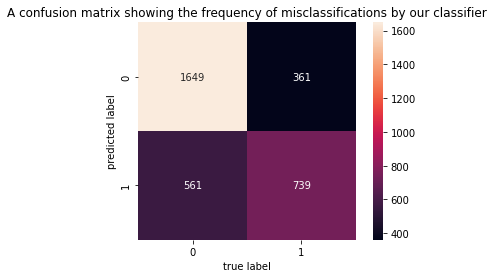

In [32]:
from sklearn.linear_model import LogisticRegression

model(LogisticRegression(), X, train_X, train_y,
      test_X, test_y, tfidf = True, cv = False, undersampled = True, oversample = False)

Feature Extraction using CV


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Accuracy Score ->  76.34441087613293
F1Score 0.7079362725382701
Precision 0.6954586589880708
Recall 0.743611703984812
Sensitivity: 49.27%
Specificity: 89.82%


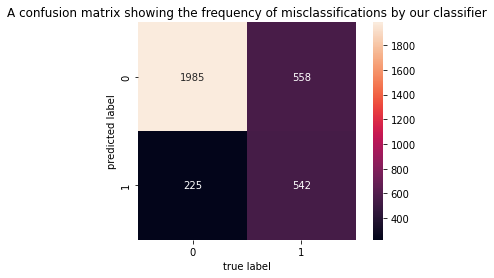

In [33]:
from sklearn.linear_model import LogisticRegression

model(LogisticRegression(), X, train_X, train_y,
      test_X, test_y, tfidf = False, cv = True, undersampled = False, oversample = False)

Feature Extraction using CV
Undersampling the dataset


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Accuracy Score ->  71.81268882175227
F1Score 0.692297621293013
Precision 0.699648292883587
Recall 0.6884242969878589
Sensitivity: 64.45%
Specificity: 75.48%


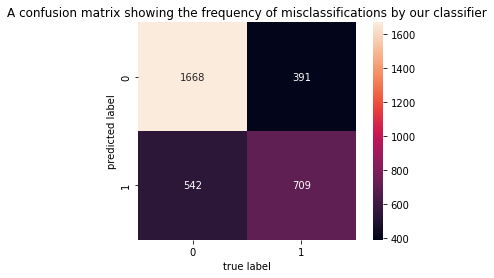

In [34]:
from sklearn.linear_model import LogisticRegression

model(LogisticRegression(), X, train_X, train_y,
      test_X, test_y, tfidf = False, cv = True, undersampled = True, oversample = False)

Feature Extraction using CV
Undersampling the dataset
Accuracy Score ->  71.72205438066466
F1Score 0.6840841708035432
Precision 0.6857280954339777
Recall 0.682667161865183
Sensitivity: 59.18%
Specificity: 77.96%


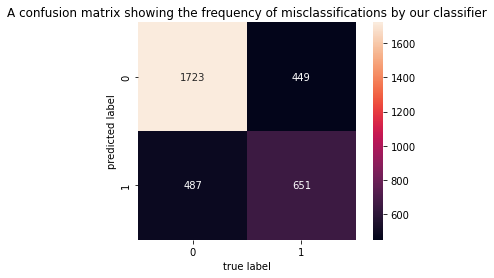

In [35]:
from sklearn.ensemble import RandomForestClassifier

model(RandomForestClassifier(n_estimators=100, max_depth=20,random_state=0), X, train_X, train_y,
      test_X, test_y, tfidf = False, cv = True, undersampled = True, oversample = False)